Шипилова Полина, 303 группа, Физический Факультет МГУ
 
 # Решение одномерного уравнения переноса

#### Импортируем необходимые библиотеки

In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm

import warnings
from IPython.display import clear_output

## Постановка задачи

Используя схему бегущего счета и итерационные методы, решить задачу:

$$
\left\{\begin{aligned}
\frac{\partial u}{\partial t} + \frac{1}{1 + u^2} \frac{\partial u}{\partial x} = 0, \ ~ 0 < x \leq 1, \\
u(x,0) = x, \\
u(0,t) = 0.
\end{aligned}\\
\right. 
$$



## Исследование задачи

### Иследование характеристик

Общий вид квазилинейного уравнения переноса
$$
u_t+F(u)u_x = 0.
$$
Уравнение характеристик имеет вид
$$
~~dt = \frac{dx}{F(u(x,t))},\ \ \ u = const.
$$
В нашем случае
$$
~~dt=\left(1+u^2\right)dx.
$$ 

Преобразуем его

$$
\int_{t_o}^{t}dt=\int_{x_o}^{x}\left(1+u^2\right)dx,
\\
$$

$$
t=\left(1+u_0^2\right)(x-x_0)+t_0, u_0 = u(x_0, t_0).
\\
$$

Воспользуемся начальным и граничным условиями для получения двух семейств кривых:

1) $~~t_0=0: ~~~~~ t=\left(1+x_0^2\right)(x-x_0)$

2) $~~x_0=0: ~~~~~ t=x+t_0$

Позже построим проекции характеристик в заданных областях и проверим пересечения кривых. В точках пересечения проекций его характеристик решение будет разрывным.

#### Уравнения характеристик

In [2]:
def f_t_0(x, x0):
    return (1+x0**2)*(x-x0)

def f_x_0(x, t0):
    return x + t0

#### Построение характеристик

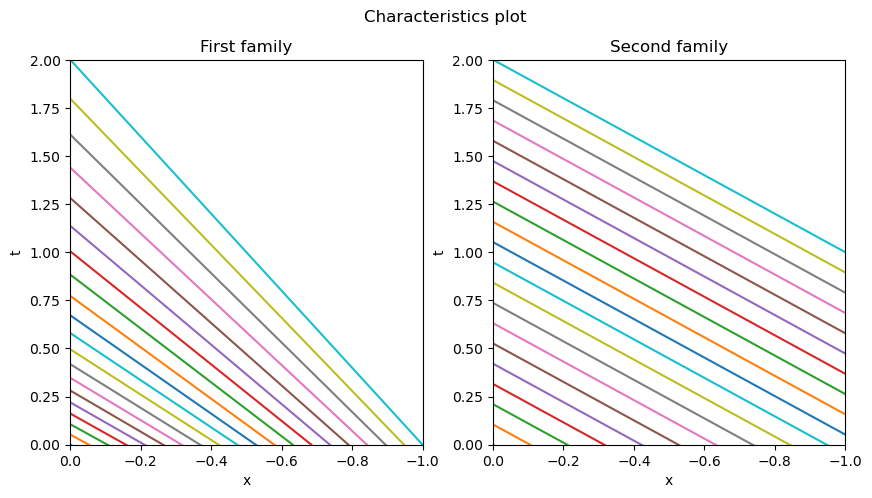

In [3]:
x_start = 0
x_end = 1
t_start = 0
t_end = 2
how_many = 20

x = np.linspace(x_start, x_end, 100)

gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(10,5))
fig.suptitle('Characteristics plot')

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_xlim(x_start, x_end)
ax1.set_ylim(t_start, t_end)
ax1.set_title('First family')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

x_for_char = np.linspace(x_start, x_end, how_many)
t_for_char = np.linspace(t_start, t_end, how_many)

for x0 in x_for_char:
    ax1.plot(x, f_t_0(x, x0))
    
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Second family')
ax2.set_xlim(x_start, x_end)
ax2.set_ylim(t_start, t_end)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
for t0 in t_for_char:
    ax2.plot(x, f_x_0(x, t0))


Итак, в данной области $x\in(0, 1]$ характеристики не пересекаются, а значит не происходит явления опрокидывания волны и профиль является однозначным. Во всей области решение будет представимо через разностную схему.

## Численное решение

### Сетка

Введем в области $\Omega=\{(x,t):0\leq x<1,~0<t<2\}$ сетку с шагом $h$ по $x$ и шагом $\tau$ по $t$:


$$
\omega_{h, \tau}=\left\{\begin{array}{l}{x_{n}=n \cdot h,\ \  h=\frac{1}{N},\ \  n=\overline{0, N}} \\ {t_{m}=m \cdot \tau,\ \ \tau=\frac{1}{M},\ \ m=\overline{0, M}}\end{array}\right.
$$

Выберем $N = M = 100$.

На $\omega_{h, ~ \tau}$ будем рассматривать сеточную функцию $u^m_{n}=u(x_n,t_m)$.

Поскольку рассматриваемое уравнение переноса является дифференциальным уравнением в частных производных первого порядка, то для его аппроксимации необходимо использовать шаблон, содержащий узлы сетки, принадлежащие как минимум двум временным и двум пространственным слоям.

### Шаблон

Приведём исходное уравнение к дивергентному виду $u_t + \left(\tilde{F}(x)\right)_x = 0$.

Так как $(\arctan x)' = \frac{1}{1+x^2}$, то уравнение преобразуется к виду

$$\frac{\partial u}{\partial t} + \frac{\partial}{\partial x}(\arctan u) = 0.$$

Соответственно, $F_n^m = F(u_n^m) = \arctan (u_n^m)$.

#### Схема "Верхний уголок"

Разностная схема в этом случе имеет вид

$$
\frac{1}{\tau}\left(u_{n+1}^{m+1} - u_{n+1}^{m}\right)+\frac{1}{h}\left(F\left(u_{n+1}^{m+1}\right) - F\left(u_{n+1}^{m}\right)\right) = 0
$$

Погрешность данной схемы $O(h + \tau)$.

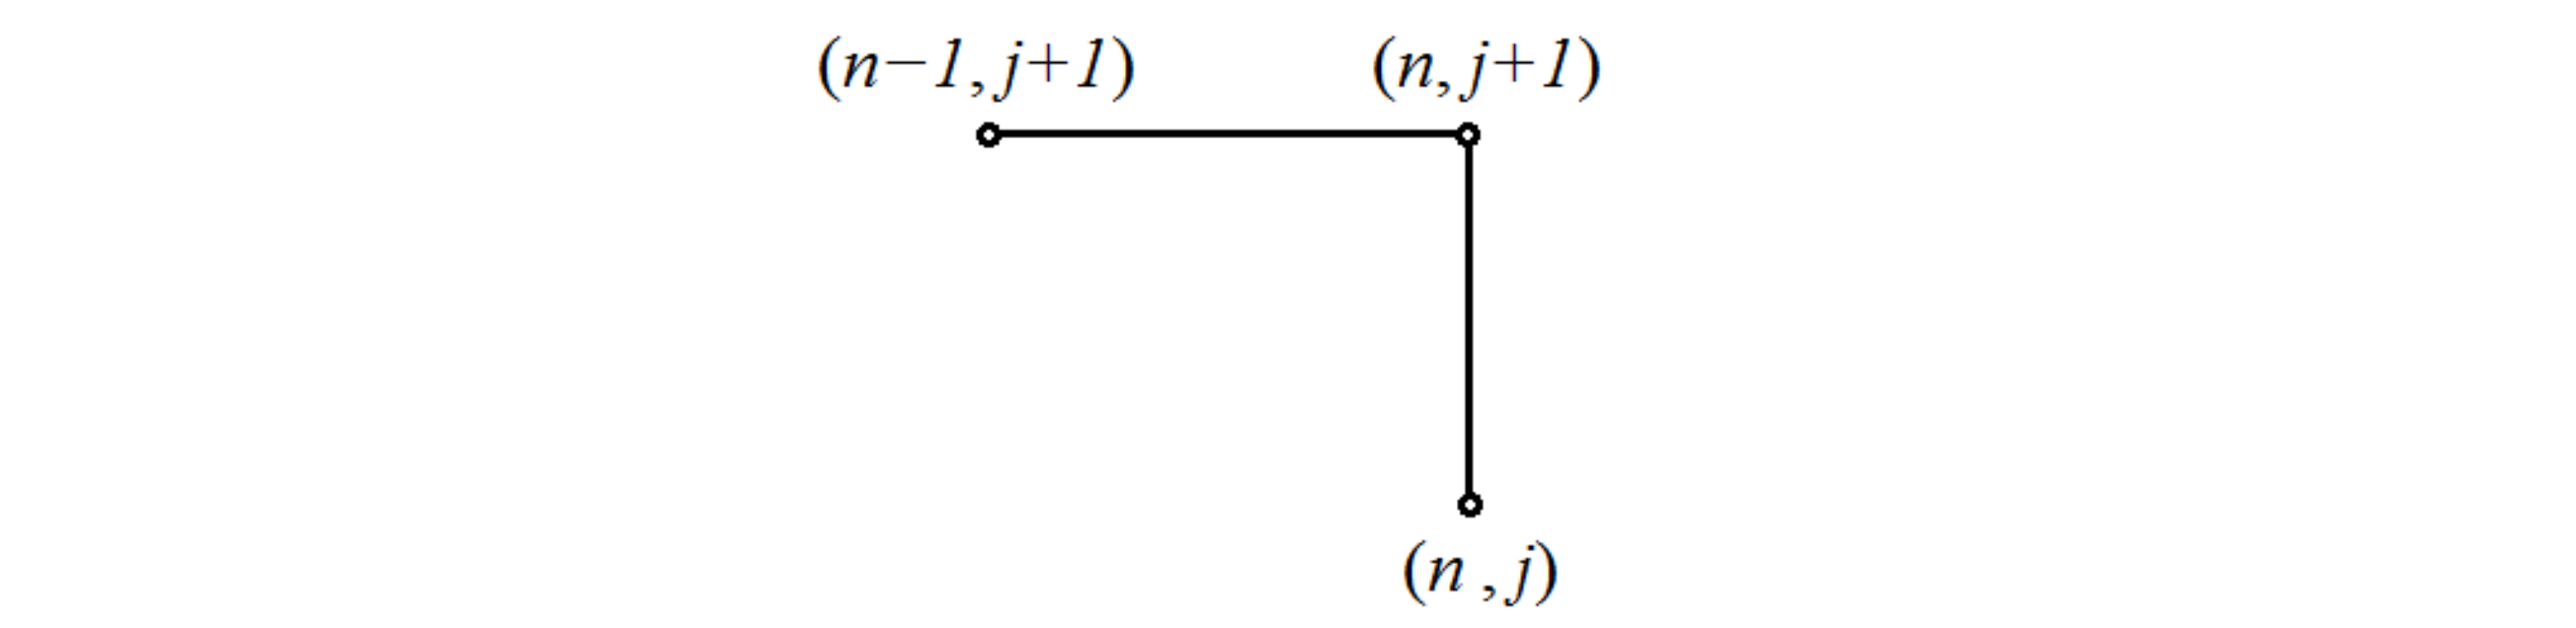

#### Схема "Квадрат"


Для рассматриваемой задачи будем использовать [четырехточечный шаблон](http://math.phys.msu.ru/data/374/tema5.pdf). Он безусловно устойчив и аппроксимирует задачу как $O({h}^2 + {\tau}^2)$.

Производная $\frac{\partial u}{\partial t}$ аппроксимируется как среднее арифметическое односторонних разностных производных по $t$, взятых при $x=x_i$ и $x=x_{i+1}$, а производная  $\frac{\partial u}{\partial x}$ — как среднее арифметическое разностных производных по $x$, взятых на слоях $j$ и $j + 1$.

Таким образом, разностная схема задачи имеет вид

$$
\frac{u_n^{m+1} - u_n^m + u_{n+1}^{m+1} - u_{n+1}^m}{2\tau} + \frac{F_{n+1}^{m+1} - F_n^{m+1} + F_{n+1}^m - F_n^m}{2h} = 0.
$$

При помощи метода Ньютона найдем корень этого уравнения - $u^{m+1}_{n+1}$ и перейдем к вычислению
следующей точки.

Используем начальное и граничное условия

$$
\left\{\begin{split}
u^0_n= n h\\
u^{m}_0 = 0
\end{split}\\
\right.
$$


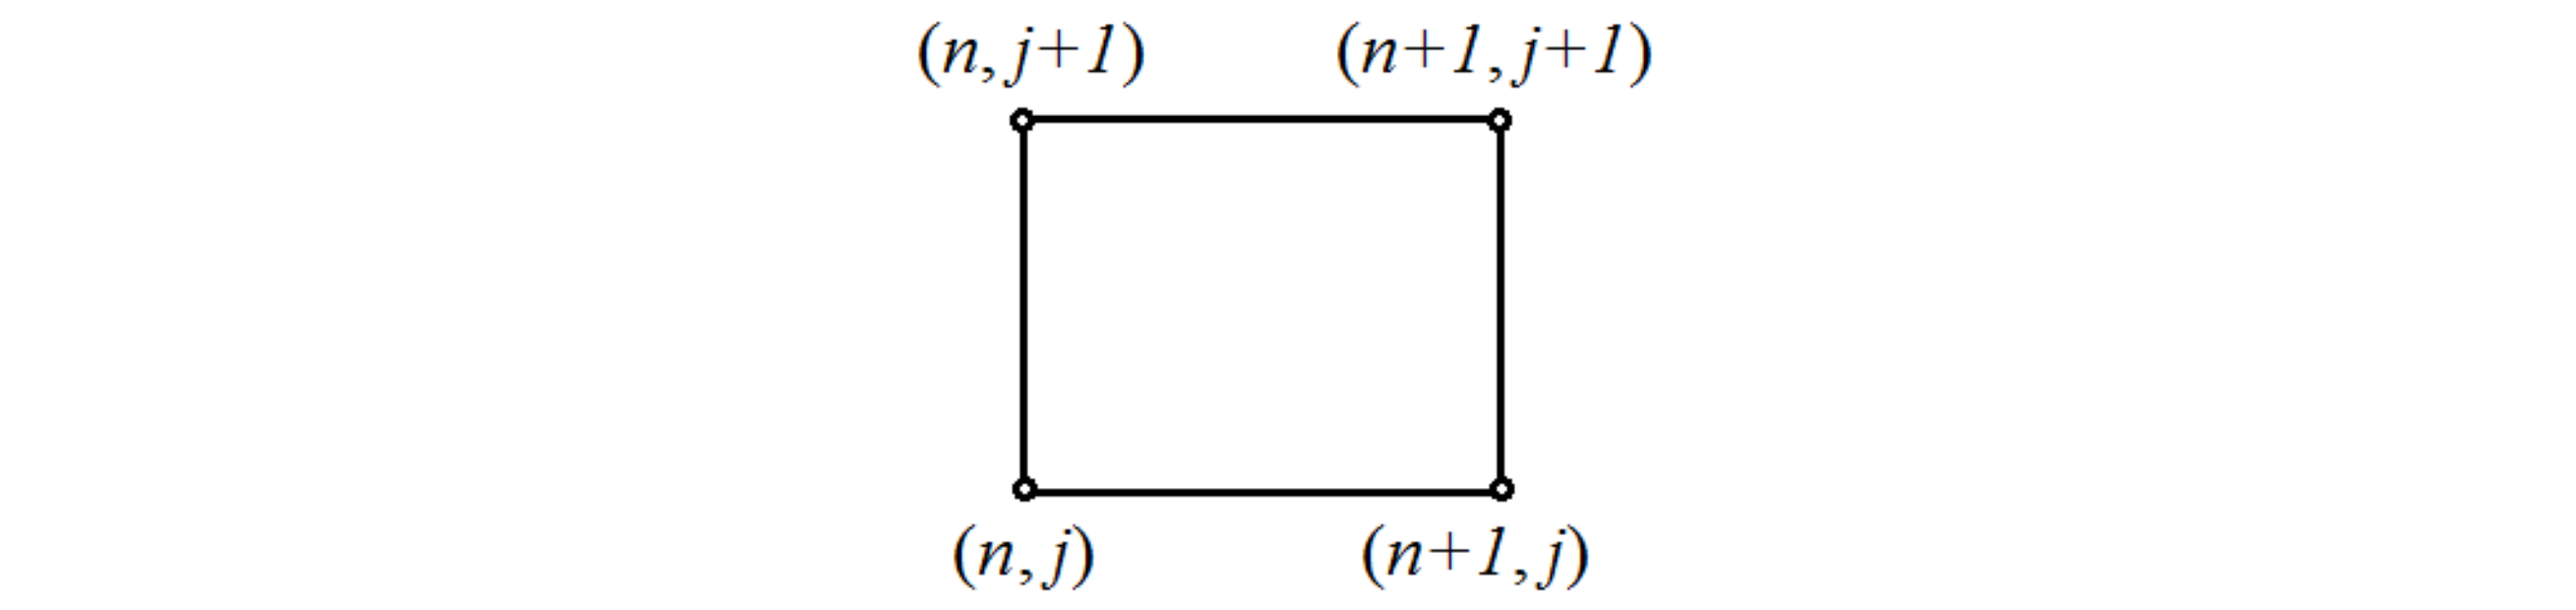

Уравнение данной схемы - это уравнение относительно $u_{n+1}^{m+1}$: $f\left(u_{n+1}^{m+1}\right) = 0$.

Таким образом разностная аппроксимация уравнения в точке $(x_n+0,5h; t_m+0,5\tau)$ имеет следующий вид

$$
\left\{\begin{split}
f\left(u_{n+1}^{m+1}\right) = \frac{u_n^{m+1} - u_n^m + u_{n+1}^{m+1} - u_{n+1}^m}{2\tau} + \frac{F_{n+1}^{m+1} - F_n^{m+1} + F_{n+1}^m - F_n^m}{2h}\\
f'\left(u_{n+1}^{m+1}\right) = \frac{1}{2\tau} + \frac{1}{1+(u_{n+1}^{m+1})^2}\cdot\frac{1}{2h}\\
u_n^0 = x_n\\
u_0^m = 0
\end{split}\\
\right. 
$$

Полученную разностную схему будем решать с помощью метода бегущего счета. Считая известными значения $t_m$ и последовательно вычисляя $u_1^{m+1},\ u_2^{m+1},\ ...,\ u_N^{m+1}$, найдем $t_{m+1}$. Корни уравнения для каждого $n$ будем искать методом Ньютона.

#### Метод Ньютона

Суть метода Ньютона заключается в итерационной последовательности 
$$u_{n+1}^{m+1^{(s+1)}} = u_{n+1}^{m+1^{(s)}} - \frac{f\left(u_{n+1}^{m+1^{(s)}}\right)}{f'\left(u_{n+1}^{m+1^{(s)}}\right)},$$
которая продолжается до тех пор, пока не будет достигнута необходимая точность $\varepsilon$: $|u_{n+1}^{m+1^{(s+1)}} - u_{n+1}^{m+1^{(s)}}| \leq \varepsilon$.

## Обоснование математической модели

### Обоснование аппроксимации

Обозначим $C\left(u_n^m\right) = arctan(u)$. Тогда разностная схема примет следующий вид: 

$$
\frac{u_{n+1}^{m+1} - u_{n+1}^m}{2\tau} + C(u)\frac{u_{n+1}^{m+1} - u_{n}^{m+1}}{2h}+\frac{u_{n}^{m+1} - u_{n}^{m}}{2\tau} + C(u)\frac{u_{n+1}^{m} - u_{n}^{m}}{2h} = 0
$$

Разложим $u(x, y)$ по формуле Тейлора около центра ячейки $\left(x_n + \frac{h}{2}; t_m + \frac{\tau}{2}\right)$.

$$
u_{n+1}^{m} = u_{n+1/2}^m + \frac{h}{2}{y'}_{n+1/2}^m + \frac{h^2}{2\cdot4}{y''}_{n+1/2}^m + \frac{h^3}{6\cdot8}{y'''}_{n+1/2}^m + O(h^4)
$$
$$
u_{n}^{m} = u_{n+1/2}^m - \frac{h}{2}{y'}_{n+1/2}^m + \frac{h^2}{2\cdot4}{y''}_{n+1/2}^m - \frac{h^3}{6\cdot8}{y'''}_{n+1/2}^m + O(h^4)
$$


Тогда 
$$
\frac{u_{n+1}^{m} - u_{n}^{m}}{2h} = \frac{1}{2h}\left(h{y'}_{n+1/2}^m + \frac{h^3}{3\cdot8}{y'''}_{n+1/2}^m + O\left(h^4\right)\right) = {y'}_{n+1/2}^m + \frac{h^2}{3\cdot8}{y'''}_{n+1/2}^m + O(h^3) = {y'}_{n+1/2}^m + O\left(h^2\right)
$$

Аналогично для приращения по временному индексу.

$$
u_{n}^{m+1} = u_{n}^{m+1/2} + \frac{\tau}{2}{y'}_{n}^{m+1/2} + \frac{\tau^2}{2\cdot4}{y''}_{n}^{m+1/2} + \frac{\tau^3}{6\cdot8}{y'''}_{n}^{m+1/2} + O(\tau^4)
$$
$$
u_{n}^{m} = u_{n}^{m+1/2} - \frac{\tau}{2}{y'}_{n}^{m+1/2} + \frac{\tau^2}{2\cdot4}{y''}_{n}^{m+1/2} - \frac{\tau^3}{6\cdot8}{y'''}_{n}^{m+1/2} + O(\tau^4)
$$


Тогда 
$$
\frac{u_{n}^{m+1/2} - u_{n}^{m}}{2\tau} = \frac{1}{2\tau}\left(\tau{y'}_{n}^{m+1/2} + \frac{\tau^3}{3\cdot8}{y'''}_{n}^{m+1/2} + O\left(\tau^4\right)\right) = \\={y'}_{n}^{m+1/2} + \frac{\tau^2}{3\cdot8}{y'''}_{n}^{m+1/2} + O(\tau^3) = {y'}_{n}^{m+1/2} + O\left(\tau^2\right)
$$

Следовательно, аппроксимация в узле $\left(x_n + \frac{h}{2}; t_m + \frac{\tau}{2}\right)$ имеет порядок $O(\tau^2 + h^2)$.

### Обоснование устойчивости

####  Необходимое условие сходимости - спектральный критерий Неймана

Воспользуемся методом «замораживания». Зафиксируем коэффициент перед $\frac{\partial u}{\partial x}$. Пусть $\gamma(u(x, t)) = \frac{1}{1+u^2}$. Тогда

$$
\frac{u^{m+1}_n - u^m_{n}}{\tau} + \gamma(x_n, t_m)\frac{u^{m}_{n+1} - u^{m}_{n}}{h}=0
$$

Фиксируем внутреннюю точку $(x_0, t_0)$ и будем искать решение в виде $u^{m}_{n} = \lambda^m e^{i\alpha n}$. Подставляя, получаем:

$$
\frac{\lambda - 1}{\tau} = \beta\frac{e^{i\alpha} - 1}{h}
$$

$$
\lambda(\alpha) = 1 + \beta\frac{\tau\left(e^{i \alpha} - 1\right)}{h}
$$

Сделав замену $r = \frac{\beta\tau}{h}$ получим $\lambda(\alpha) = 1 - r + re^{i\alpha}$.

Спектр $\lambda(\alpha)$ - щкружность на комплексной плоскости радиусом r и имеющая центр в точке $1-r$.

$$
|\lambda(\alpha)| \leq 1\ \ \Rightarrow\ \ r\leq1\ \ \Rightarrow\ \ max\left[\frac{\gamma\tau}{h}\right]\leq1
$$

$$
\tau = h\ \Rightarrow\ max[\gamma]\leq1
$$

Исследуем $\gamma(u)$ на экстремумы

$$
\frac{\partial \gamma}{\partial u} = \frac{2u}{(1+u^2)^2} = 0\\
u = 0\\
\gamma(0) = 1 \leq1
$$

Таким образом условие $|\lambda(\alpha)|\leq1$ выполнено для любых значений шага по времени и координате, следовательно, спектральный критерий Неймана также выполнен для любых $\tau,\ h$. Поэтому данная схема безусловно устойчива.

#### Достаточное условие сходимости - критерий Куранта

Представим разностную схему в виде

$$
u_{n+1}^{m+1}\left(1-\frac{C\tau}{h}\right) + u_{n}^{m+1}\left(1+\frac{C\tau}{h}\right) = u_{n}^{m}\left(1-\frac{C\tau}{h}\right) + u_{n+1}^{m}\left(1+\frac{C\tau}{h}\right)
$$

Оценим это равенство по норме

$$
||u^{m+1}||\left(1-\frac{C\tau}{h}\right) + ||u^{m+1}||\left(1+\frac{C\tau}{h}\right) \leq 2||u^m||,
$$

$$
||u^{m+1}|| \leq ||u^m|| \leq ||u^{m-1}|| \leq ... \leq ||u^0|| = ||\varphi||.
$$

То есть критерий Куранта выполняется.

## Численный расчёт

Зададим: $\varepsilon$ - точность в методе Ньютона, $N$ - количество шагов по $x$, $М$ - количество шагов по $t$, а также границы нашей сетки. 

In [10]:
X_START = 0
X_END = -1
T_START = 0
T_END = 2
error = 0.001
i_max = 10000
        
def calculate_u(u, N, M, dt, dx):
    for n in range(1, N):
        for m in range(1, M):
            # Определение точек, на которых будет работать шаблон
            u11 = u[m-1][n-1]
            u21 = u[m-1][n]
            u12 = u[m][n-1]

            # Вычисление значения u в новой точке
            u_new = solve_newton(u21, u12, u11, dt, dx)
            u[m][n] = u_new
    return u

def solve_newton(u21, u12, u11, dt, dx):
    x = u11
    i = 0
    while np.abs(f(u12, u11, u21, x, dt, dx)) > error and i < i_max:
        x += (-f(u12, u11, u21, x, dt, dx) / f_div(x, dt, dx))
        i+=1
    return x

Конкретные функции

In [5]:
def C(u):
    return (-1) / (1 + u ** 2)

def C_integral(u):
    return -np.arctan(u)

def f(u12, u11, u21, u22, dt, dx):
    return 0.5*(u12 - u11 + u22 - u21) / dt + 0.5*(C_integral(u22) - C_integral(u12) + C_integral(u21) - C_integral(u11)) / dx

def f_div(u22, dt, dx):
    return 0.5 / dt + 0.5*(C(u22)) / dx 

Вычислим значение функции u(x, t) во всех точках сетки.

In [11]:
def diff_scheme(N=10, M=10):
    x = np.linspace(X_START, X_END, N)
    t = np.linspace(T_START, T_END, M)
    
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    u = np.empty((M, N))

    for n in np.arange(N):
        u[0][n] = -dx * n
    for m in np.arange(M):
        u[m][0] = 0
        
    return calculate_u(u, N, M, dt, dx)

In [12]:
scheme10 = diff_scheme(10, 10)
scheme20 = diff_scheme(20, 20)
scheme30 = diff_scheme(30, 30)
scheme50 = diff_scheme(50, 50)
scheme80 = diff_scheme(80, 80)
scheme100 = diff_scheme(100, 100)

[ 0.         -0.11111111 -0.22222222 -0.33333333 -0.44444444 -0.55555556
 -0.66666667 -0.77777778 -0.88888889 -1.        ]
-0.1111111111111111
[ 0.         -0.05263158 -0.10526316 -0.15789474 -0.21052632 -0.26315789
 -0.31578947 -0.36842105 -0.42105263 -0.47368421 -0.52631579 -0.57894737
 -0.63157895 -0.68421053 -0.73684211 -0.78947368 -0.84210526 -0.89473684
 -0.94736842 -1.        ]
-0.05263157894736842
[ 0.         -0.03448276 -0.06896552 -0.10344828 -0.13793103 -0.17241379
 -0.20689655 -0.24137931 -0.27586207 -0.31034483 -0.34482759 -0.37931034
 -0.4137931  -0.44827586 -0.48275862 -0.51724138 -0.55172414 -0.5862069
 -0.62068966 -0.65517241 -0.68965517 -0.72413793 -0.75862069 -0.79310345
 -0.82758621 -0.86206897 -0.89655172 -0.93103448 -0.96551724 -1.        ]
-0.034482758620689655
[ 0.         -0.02040816 -0.04081633 -0.06122449 -0.08163265 -0.10204082
 -0.12244898 -0.14285714 -0.16326531 -0.18367347 -0.20408163 -0.2244898
 -0.24489796 -0.26530612 -0.28571429 -0.30612245 -0.3265306

### Визуализация решения

Решение при фиксированном $t$

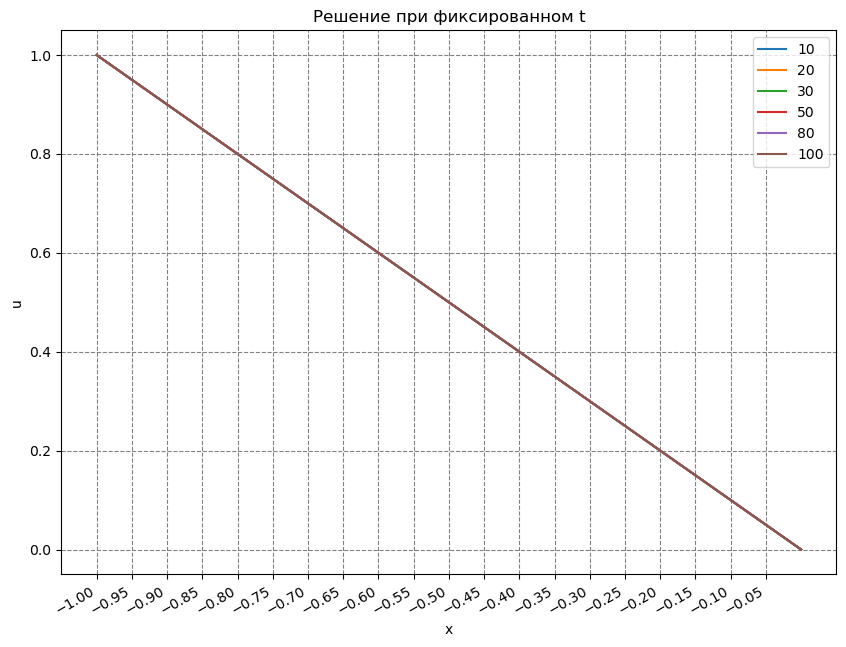

In [18]:
fig2 = plt.figure(figsize=(10,8))

xn10 = np.linspace(X_START, X_END, num = 10)
xn20 = np.linspace(X_START, X_END, num = 20)
xn30 = np.linspace(X_START, X_END, num = 30)
xn50 = np.linspace(X_START, X_END, num = 50)
xn80 = np.linspace(X_START, X_END, num = 80)
xn100 = np.linspace(X_START, X_END, num = 100)

plt.plot(xn10, scheme10[0], label='10')
plt.plot(xn20, scheme20[0], label='20')
plt.plot(xn30, scheme30[0], label='30')
plt.plot(xn50, scheme50[0], label='50')
plt.plot(xn80, scheme80[0], label='80')
plt.plot(xn100, scheme100[0], label='100')

plt.title('Решение при фиксированном t')
plt.xlabel('x')
plt.ylabel('u')
plt.xticks(np.arange(-1,0,0.05))
fig2.autofmt_xdate()
plt.grid(which='major', color = 'gray',ls='--')
plt.legend()
plt.show()

Различные сетки

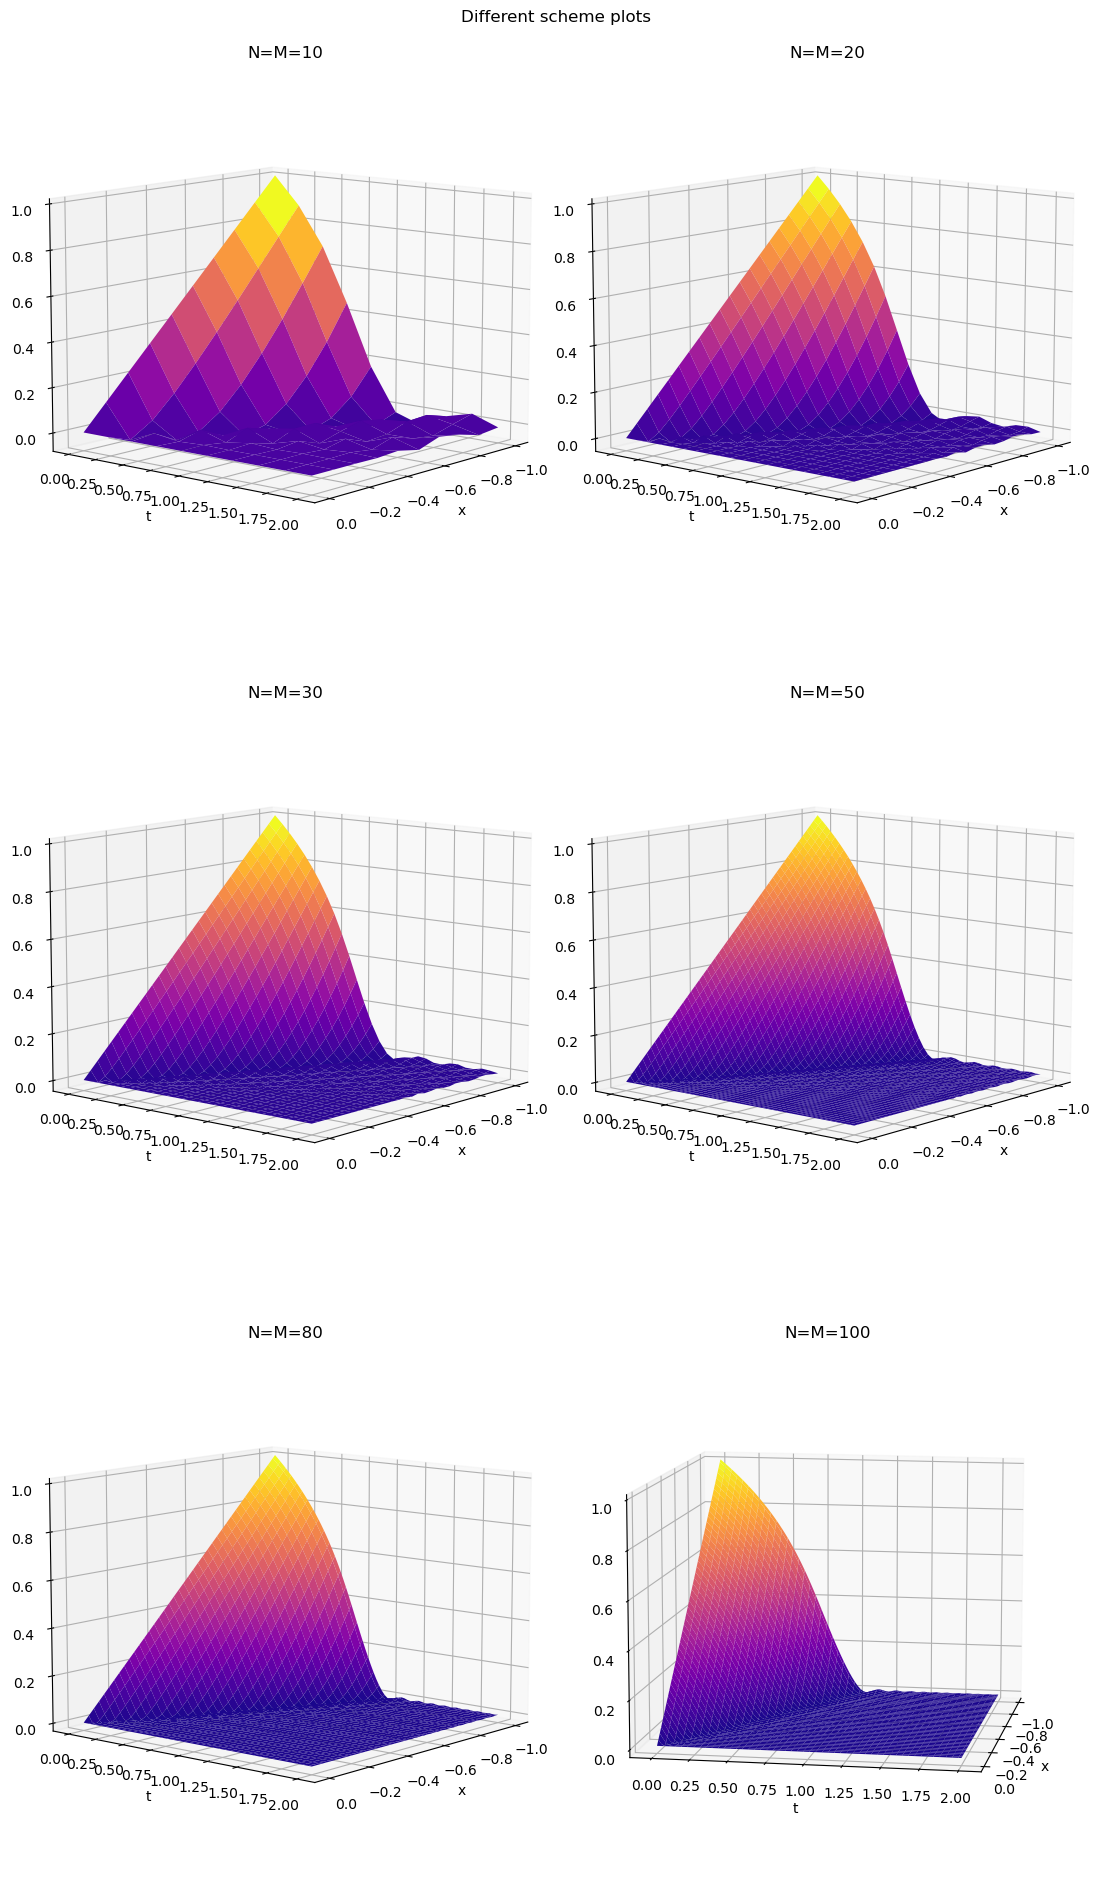

In [17]:
tm10 = np.linspace(T_START, T_END, num = 10)
tm20 = np.linspace(T_START, T_END, num = 20)
tm30 = np.linspace(T_START, T_END, num = 30)
tm50 = np.linspace(T_START, T_END, num = 50)
tm80 = np.linspace(T_START, T_END, num = 80)
tm100 = np.linspace(T_START, T_END, num = 100)

X10, T10 = np.meshgrid(xn10, tm10)
X20, T20 = np.meshgrid(xn20, tm20)
X30, T30 = np.meshgrid(xn30, tm30)
X50, T50 = np.meshgrid(xn50, tm50)
X80, T80 = np.meshgrid(xn80, tm80)
X100, T100 = np.meshgrid(xn100, tm100)

fig, ax = plt.subplots(3, 2, subplot_kw={"projection": "3d"}, figsize=(11,20))
fig.tight_layout()

# fig.subplots_adjust(hspace=None)
fig.suptitle('Different scheme plots')
ax[0, 0].plot_surface(X10, T10, scheme10, vmin=scheme10.min() * 2, cmap=mpl.colormaps['plasma'])
ax[0,0].set_title('N=M=10')
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('t')
ax[0,0].view_init(10, 40)

ax[0,1].plot_surface(X20, T20, scheme20, vmin=scheme20.min() * 2, cmap=mpl.colormaps['plasma'])
ax[0,1].set_title('N=M=20')
ax[0,1].set_xlabel('x')
ax[0,1].set_ylabel('t')
ax[0,1].view_init(10, 40)

ax[1,0].plot_surface(X30, T30, scheme30, vmin=scheme30.min() * 2, cmap=mpl.colormaps['plasma'])
ax[1,0].set_title('N=M=30')
ax[1,0].set_xlabel('x')
ax[1,0].set_ylabel('t')
ax[1,0].view_init(10, 40)

ax[1,1].plot_surface(X50, T50, scheme50, vmin=scheme50.min() * 2, cmap=mpl.colormaps['plasma'])
ax[1,1].set_title('N=M=50')
ax[1,1].set_xlabel('x')
ax[1,1].set_ylabel('t')
ax[1,1].view_init(10, 40)

ax[2,0].plot_surface(X80, T80, scheme80, vmin=scheme80.min() * 2, cmap=mpl.colormaps['plasma'])
ax[2,0].set_title('N=M=80')
ax[2,0].set_xlabel('x')
ax[2,0].set_ylabel('t')
ax[2,0].view_init(10, 40)

ax[2,1].plot_surface(X100, T100, scheme100, vmin=scheme100.min() * 2, cmap=mpl.colormaps['plasma'])
ax[2,1].set_title('N=M=100')
ax[2,1].set_xlabel('x')
ax[2,1].set_ylabel('t')
ax[2,1].view_init(10, 10)